*This notebook defines functions that are used to further preprocess and clean the brain scans. Firstly, the functions get rid of any artefacts that may be present in a scan -- this is done by setting the intensity value of those voxels to the threshold value. Secondly, we apply histogram matching to all the scans using a unique reference scan for the PETMR and TRIO datasets.*

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

In [2]:
import nibabel as nib
import numpy as np
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [4]:
#this function simply uploads the selected scan, (It is used for the refernce scan only)

def get_scan(petmr=False, trio=False, ref=False, subj=None, scan=None, thresholded=False):
    
    if ref == True:
        # Paths to the ref scans
        print "Fetching reference scan"
        petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data/ReferenceScan'
        trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/ReferenceScan'
    else:
        print "Fetching subject scan"
        petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data/Subj' + str(subj) + 'Scan' + str(scan)
        trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/Subj' + str(subj) + 'Scan' + str(scan)
    
    if(petmr == True):
        print "Uploading PETMR scan"
        data_path = petmr_data_path
    else:
        print "Uploading Trio scan"
        data_path = trio_data_path
    os.chdir(data_path)
    if ref == True:
        scan_image = nib.load(str(data_path) + '/Ref_Scan.nii.gz')
    elif thresholded == True:
        scan_image = nib.load(str(data_path) + '/Brain_Thresholded.nii.gz')
    else:
        scan_image = nib.load(str(data_path) + '/Brain_Extracted.nii.gz')
        
    scan_data = scan_image.get_data()
    bvals_scan, bvecs_scan = read_bvals_bvecs(str(data_path) + "/NODDI.bval",\
                                              str(data_path) + "/NODDI.bvec")
    #set a threshold value for b=0 values (due to TRIO dataset)
    gtab_scan = gradient_table(bvals_scan, bvecs_scan, b0_threshold=5)
        
    # Extract the b=0 volumes only
    scan_data_b0s = scan_data[:,:,:,gtab_scan.b0s_mask]

    return (scan_data_b0s)

In [5]:
def analysis(scan, gtable, title, threshold):
    
    # Extract the b=0 volumes from the scan
    b_0s = scan[:,:,:,gtable.b0s_mask]
    
    mask = b_0s>0
    brain = b_0s[mask]
    
    
    print("maximum: %d" % brain.max())
    print("minimum: %d" % brain.min())
    print("average: %d" % brain.mean())
    print("median: %d" % np.median(brain))

    print("Total number of voxels: %d" % brain.shape[0])
    print("Voxels greater than threshold value (%d): %f" % (threshold, (brain>threshold).sum()))

    plt.hist(brain.flatten(), bins = 1024);
    plt.title(title)




In [6]:
# We threshold using b=700 values as this is more robust in identifying artefacts
# Use all b=700 values then take the union of them
def threshold(full_scan, gtab, threshold):
    
    # Make the assumption that the first b=700 volume lies at postion 2
    b_700 = full_scan[:,:,:, (gtab.bvals == 700)]

    # Identify the voxels that lie above the threshold level
    bool_matrix = b_700 > threshold
    
    # Combine the identified voxels using a union opertaion in a single scan
    bool_matrix = np.logical_or.reduce(bool_matrix, axis=3)
    
    return bool_matrix

In [7]:
# Algorithm for performing histogram matching
# Matching is only performed on b=0 volumes
# We also only consider non-zero voxels when performing the matching


def hist_match(general_scan, reference_scan):
    
    

    oldshape = general_scan.shape
    source = general_scan.ravel()
    reference = reference_scan.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    
    #bin_idx returns the index of the unique element in terms of the unique array
    #returns the index of a value in s_values
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference, return_counts=True)
    
    # remove the first element from s_counts, t_counts and t_values as these values correspond to 0 intensity
    # we do not want to consider background voxels

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts[1:]).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    r_quantiles = np.cumsum(r_counts[1:]).astype(np.float64)
    r_quantiles /= r_quantiles[-1]
    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image

    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values[1:])
    
    # the interpoltaed values do not contain the intensity value 0
    # add this to the start of the list
    interp_r_values = np.insert(interp_r_values, 0, 0)

    return interp_r_values[bin_idx].reshape(oldshape)

In [7]:
def viz_pred(before, reference, after, sliceNo, scale):
    if scale == False:
        plt.figure
        plt.figure(figsize=(10,10))
        plt.subplot(1, 3, 1).set_axis_off()
        plt.imshow(before[:,:,sliceNo,0].T, cmap='gray', origin='lower')
        plt.title("Initial")
        plt.subplot(1, 3, 2).set_axis_off()
        plt.imshow(reference[:,:,sliceNo,0].T, cmap='gray', origin='lower')
        plt.title("Reference")
        plt.subplot(1, 3, 3).set_axis_off()
        plt.imshow(after[:,:,sliceNo,0].T, cmap='gray', origin='lower')
        plt.title("Matched")
        plt.show()
    else:
        max1 = np.max(before)
        max2 = np.max(reference)
        if max1 > max2:
            maximum = max1
        else:
            maximum = max2
        plt.figure
        plt.figure(figsize=(10,10))
        plt.subplot(1, 3, 1).set_axis_off()
        plt.imshow(before[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
        plt.title("Initial")
        plt.subplot(1, 3, 2).set_axis_off()
        plt.imshow(reference[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
        plt.title("Reference")
        plt.subplot(1, 3, 3).set_axis_off()
        plt.imshow(after[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
        plt.title("Matched")
        plt.show()

In [8]:
# Paths to the data scans
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data'

### Create PETMR referece scan
 
We identify a reference scan based on how *clean* the scan is -- it should contain minimal artefacts and should have a reasonable range with minimal high intensity voxels.
 
##### Use Subject 1 Scan 2 as the refernce scan - Threshold = 2400

In [9]:
# Get the PETMR reference scan
petmr_reference = get_scan(petmr=True, ref=True)

Fetching reference scan
Uploading PETMR scan


### Create TRIO referece scan
 
We identify a reference scan based on how *clean* the scan is -- it should contain minimal artefacts and should have a reasonable range with minimal high intensity voxels.
 
##### Use Subject 2 Scan 2 as the refernce scan (modeified with thresholding - replace with 0)  - Threshold = 1100

In [10]:
# Get the Trio reference scan
trio_reference = get_scan(trio=True, ref=True)

Fetching reference scan
Uploading Trio scan


## Apply thresholding and Histogram matching to all PETMR scans


In [18]:
# Iterate through all PETMR scans, apply threshoding and histogram matching to each scan
def threshold_and_match(ref_scan, threshold_val, petmr=False, trio=False):

    subjects = [1,2,3,4,5,6,7,8,9,10]
    scans = [1,2]
    if(petmr == True):
        print "Uploading PETMR scans:"
        data_path = petmr_data_path
    else:
        print "Uploading Trio scans:"
        data_path = trio_data_path
    for subject in subjects:
        for scan in scans:
            os.chdir(data_path)
            print "Subj%dScan%d" % (subject, scan)
            scan_image = nib.load(str(data_path) + "/Subj" + str(subject) + "Scan" + str(scan) + "/Brain_Extracted.nii.gz")
            scan_data = scan_image.get_data()
            affine_mat = scan_image.affine
            bvals_scan, bvecs_scan = read_bvals_bvecs(str(data_path) + "/Subj" + str(subject) + "Scan" + str(scan)  + "/NODDI.bval",\
                                                      str(data_path) + "/Subj" + str(subject) + "Scan" + str(scan)  + "/NODDI.bvec")
            gtab_scan = gradient_table(bvals_scan, bvecs_scan, b0_threshold=5)
            
            # identify threshold voxels - replace with 0
            #threshold_matrix = threshold(scan_data, gtab_scan, threshold_val)
            #scan_data[threshold_matrix, :] = 0
            
            # Perform histogram matching on the thresholded scan (use b=0 values only)
            scan_b_0s = scan_data[:,:,:,gtab_scan.b0s_mask]
            matched_scan = hist_match(scan_b_0s, ref_scan)
            
            # Replace the new matched b=0 volumes into the full thresholded scan
            scan_data[:,:,:,gtab_scan.b0s_mask] = matched_scan
            
            # Replace the threshodled voxels with a value of -5
            #scan_data[threshold_matrix, :] = -5
            
            # Save this new scan
            new_scan_img = nib.Nifti1Image(scan_data.astype(np.float32), affine_mat)
            nib.save(new_scan_img, str(data_path)+  "/Subj" + str(subject) + "Scan" + str(scan)  + "/Brain_Thresholded.nii.gz")
            
    return gtab_scan 
        

In [19]:
gtab = threshold_and_match(petmr_reference, 550, petmr=True)

Uploading PETMR scans:
Subj1Scan1
Subj1Scan2
Subj2Scan1
Subj2Scan2
Subj3Scan1
Subj3Scan2
Subj4Scan1
Subj4Scan2
Subj5Scan1
Subj5Scan2
Subj6Scan1
Subj6Scan2
Subj7Scan1
Subj7Scan2
Subj8Scan1
Subj8Scan2
Subj9Scan1
Subj9Scan2
Subj10Scan1
Subj10Scan2


In [20]:
gtab = threshold_and_match(trio_reference, 450, trio=True)

Uploading Trio scans:
Subj1Scan1
Subj1Scan2
Subj2Scan1
Subj2Scan2
Subj3Scan1
Subj3Scan2
Subj4Scan1
Subj4Scan2
Subj5Scan1
Subj5Scan2
Subj6Scan1
Subj6Scan2
Subj7Scan1
Subj7Scan2
Subj8Scan1
Subj8Scan2
Subj9Scan1
Subj9Scan2
Subj10Scan1
Subj10Scan2


# Visual Analysis

In [22]:
# Get PETMR scans for Subj1Scan1
scan1_normal = get_scan(petmr=True, subj=1, scan=1)
scan1_thresholded = get_scan(petmr=True, subj=1, scan=1, thresholded=True)

Fetching subject scan
Uploading PETMR scan
Fetching subject scan
Uploading PETMR scan


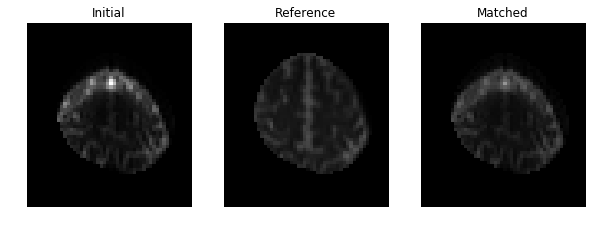

In [23]:
viz_pred(scan1_normal, petmr_reference, scan1_thresholded, 40, True)

In [17]:
scan1_thresholded.min()

-5.0

In [ ]:
# Get PETMR scans for Subj1Scan1
scan1_normal = get_scan(petmr=True, subj=1, scan=1)
scan1_thresholded = get_scan(petmr=True, subj=1, scan=1, thresholded=True)